<a href="https://colab.research.google.com/github/ganeshmukhiya/Topic-Modeling-NMF/blob/main/recontruction%20vs%20chorence%20vs%20topic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

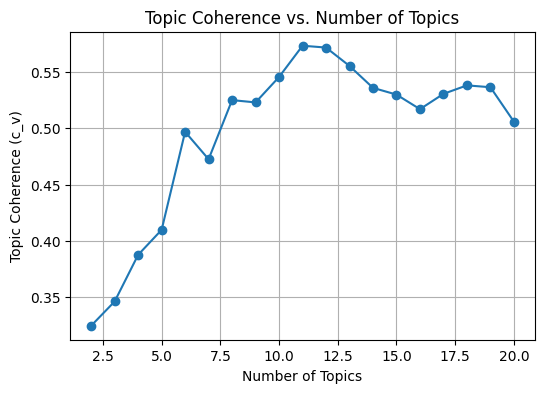

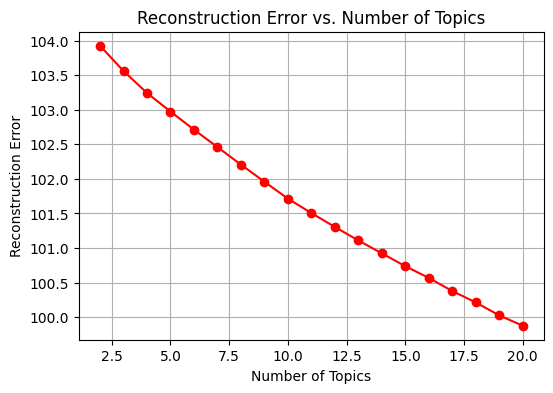

Sparsity of TF-IDF matrix: 3.01%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train')
data = newsgroups_train.data

# Preprocess the data using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(data)

# Tokenize the data for coherence calculation
def preprocess(text):
    return [word for word in text.lower().split() if word not in vectorizer.get_stop_words()]

tokenized_data = [preprocess(doc) for doc in data]

# Define function to calculate coherence score
def calculate_coherence(nmf_model, feature_names, tokenized_data):
    topics = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_features_indices = topic.argsort()[-10:][::-1]  # Top 10 words
        top_features = [feature_names[i] for i in top_features_indices]
        topics.append(top_features)

    # Create Gensim dictionary and corpus for coherence model
    dictionary = Dictionary(tokenized_data)
    corpus = [dictionary.doc2bow(text) for text in tokenized_data]

    # Calculate coherence score
    coherence_model = CoherenceModel(topics=topics, texts=tokenized_data, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# List to store coherence scores and reconstruction errors
coherence_scores = []
reconstruction_errors = []

# Range of topics to evaluate
topic_range = range(2, 21)

# Calculate coherence and reconstruction error for each number of topics
for n_topics in topic_range:
    nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvd')
    W = nmf_model.fit_transform(X)
    H = nmf_model.components_

    # Calculate reconstruction error
    reconstruction_error = nmf_model.reconstruction_err_
    reconstruction_errors.append(reconstruction_error)

    # Get the feature names (terms)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate coherence score
    coherence = calculate_coherence(nmf_model, feature_names, tokenized_data)
    coherence_scores.append(coherence)

# Plot Topic Coherence vs. Number of Topics
plt.figure(figsize=(6, 4))
plt.plot(topic_range, coherence_scores, marker='o')
plt.title('Topic Coherence vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Topic Coherence (c_v)')
plt.grid(True)
plt.show()

# Plot Reconstruction Error vs. Number of Topics
plt.figure(figsize=(6, 4))
plt.plot(topic_range, reconstruction_errors, marker='o', color='red')
plt.title('Reconstruction Error vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

# Calculate and print sparsity ratio
sparsity_ratio = (X.nnz / float(X.shape[0] * X.shape[1])) * 100
print(f'Sparsity of TF-IDF matrix: {sparsity_ratio:.2f}%')
